In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import resample

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
class LoanDefaultPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.model = None
        
    def load_data(self, file_path):
        """Step 1: Load the dataset"""
        print("Step 1: Loading the dataset...")
        try:
            self.df = pd.read_csv(file_path)
            print(f"Dataset loaded successfully!")
            print(f"Dataset shape: {self.df.shape}")
            print(f"Columns: {list(self.df.columns)}")
            return self.df
        except Exception as e:
            print(f"Error loading dataset: {e}")
            # For demonstration, create a sample dataset
            print("Creating sample dataset for demonstration...")
            self.create_sample_data()
            return self.df
    
    def create_sample_data(self):
        """Create sample loan dataset for demonstration"""
        np.random.seed(42)
        n_samples = 10000
        
        self.df = pd.DataFrame({
            'TARGET': np.random.choice([0, 1], size=n_samples, p=[0.92, 0.08]),  # Imbalanced
            'CODE_GENDER': np.random.choice(['M', 'F'], size=n_samples, p=[0.7, 0.3]),
            'FLAG_OWN_CAR': np.random.choice(['Y', 'N'], size=n_samples, p=[0.3, 0.7]),
            'FLAG_OWN_REALTY': np.random.choice(['Y', 'N'], size=n_samples, p=[0.7, 0.3]),
            'CNT_CHILDREN': np.random.poisson(0.4, n_samples),
            'AMT_INCOME_TOTAL': np.random.lognormal(11.5, 0.5, n_samples),
            'AMT_CREDIT': np.random.lognormal(13, 0.7, n_samples),
            'AMT_ANNUITY': np.random.lognormal(9.5, 0.5, n_samples),
            'AMT_GOODS_PRICE': np.random.lognormal(12.5, 0.8, n_samples),
            'NAME_TYPE_SUITE': np.random.choice(['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other_A', 'Other_B', 'Group of people'], size=n_samples),
            'NAME_INCOME_TYPE': np.random.choice(['Working', 'Commercial associate', 'Pensioner', 'State servant', 'Unemployed', 'Student', 'Businessman', 'Maternity leave'], size=n_samples),
            'NAME_EDUCATION_TYPE': np.random.choice(['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree'], size=n_samples),
            'NAME_FAMILY_STATUS': np.random.choice(['Single / not married', 'Married', 'Civil marriage', 'Widow', 'Separated'], size=n_samples),
            'NAME_HOUSING_TYPE': np.random.choice(['House / apartment', 'Rented apartment', 'With parents', 'Municipal apartment', 'Office apartment', 'Co-op apartment'], size=n_samples),
            'REGION_POPULATION_RELATIVE': np.random.uniform(0.0001, 0.1, n_samples),
            'DAYS_BIRTH': -np.random.randint(18*365, 70*365, n_samples),  # Age in days (negative)
            'DAYS_EMPLOYED': -np.random.randint(0, 40*365, n_samples),  # Employment duration (negative)
            'DAYS_REGISTRATION': -np.random.randint(0, 50*365, n_samples),
            'DAYS_ID_PUBLISH': -np.random.randint(0, 20*365, n_samples),
            'OWN_CAR_AGE': np.random.exponential(7, n_samples),
            'FLAG_MOBIL': np.random.choice([0, 1], size=n_samples, p=[0.01, 0.99]),
            'FLAG_EMP_PHONE': np.random.choice([0, 1], size=n_samples, p=[0.2, 0.8]),
            'FLAG_WORK_PHONE': np.random.choice([0, 1], size=n_samples, p=[0.8, 0.2]),
            'FLAG_CONT_MOBILE': np.random.choice([0, 1], size=n_samples, p=[0.01, 0.99]),
            'FLAG_PHONE': np.random.choice([0, 1], size=n_samples, p=[0.7, 0.3]),
            'FLAG_EMAIL': np.random.choice([0, 1], size=n_samples, p=[0.4, 0.6]),
            'OCCUPATION_TYPE': np.random.choice(['Laborers', 'Core staff', 'Sales staff', 'Managers', 'Drivers', 'High skill tech staff', 'Accountants', 'Medicine staff', 'Security staff', 'Cooking staff', 'Cleaning staff', 'Private service staff', 'Low-skill Laborers', 'Waiters/barmen staff', 'Secretaries', 'Realty agents', 'HR staff', 'IT staff'], size=n_samples),
            'CNT_FAM_MEMBERS': np.random.randint(1, 8, n_samples),
            'REGION_RATING_CLIENT': np.random.randint(1, 4, n_samples),
            'REGION_RATING_CLIENT_W_CITY': np.random.randint(1, 4, n_samples),
            'WEEKDAY_APPR_PROCESS_START': np.random.choice(['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY'], size=n_samples),
            'HOUR_APPR_PROCESS_START': np.random.randint(0, 24, n_samples),
            'REG_REGION_NOT_LIVE_REGION': np.random.choice([0, 1], size=n_samples, p=[0.95, 0.05]),
            'REG_REGION_NOT_WORK_REGION': np.random.choice([0, 1], size=n_samples, p=[0.9, 0.1]),
            'LIVE_REGION_NOT_WORK_REGION': np.random.choice([0, 1], size=n_samples, p=[0.85, 0.15]),
            'REG_CITY_NOT_LIVE_CITY': np.random.choice([0, 1], size=n_samples, p=[0.9, 0.1]),
            'REG_CITY_NOT_WORK_CITY': np.random.choice([0, 1], size=n_samples, p=[0.85, 0.15]),
            'LIVE_CITY_NOT_WORK_CITY': np.random.choice([0, 1], size=n_samples, p=[0.8, 0.2]),
        })
        
        # Add some missing values to make it realistic
        missing_cols = ['OCCUPATION_TYPE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS']
        for col in missing_cols:
            if col in self.df.columns:
                missing_idx = np.random.choice(self.df.index, size=int(0.1 * len(self.df)), replace=False)
                self.df.loc[missing_idx, col] = np.nan
        
        print("Sample dataset created successfully!")
    
    def check_null_values(self):
        """Step 2: Check for null values in the dataset"""
        print("\nStep 2: Checking for null values...")
        null_counts = self.df.isnull().sum()
        null_percentages = (null_counts / len(self.df)) * 100
        
        null_info = pd.DataFrame({
            'Null_Count': null_counts,
            'Null_Percentage': null_percentages
        })
        
        null_info = null_info[null_info['Null_Count'] > 0].sort_values('Null_Count', ascending=False)
        
        if not null_info.empty:
            print("Columns with null values:")
            print(null_info)
        else:
            print("No null values found in the dataset!")
        
        return null_info
    
    def analyze_target_distribution(self):
        """Step 3: Print the percentage of default to payer for TARGET column"""
        print("\nStep 3: Analyzing TARGET column distribution...")
        
        target_counts = self.df['TARGET'].value_counts()
        target_percentages = self.df['TARGET'].value_counts(normalize=True) * 100
        
        print("TARGET Distribution:")
        print("Value Counts:")
        print(target_counts)
        print("\nPercentages:")
        for value, percentage in target_percentages.items():
            status = "Default" if value == 1 else "Payer"
            print(f"{status} (TARGET={value}): {percentage:.2f}%")
        
        # Calculate imbalance ratio
        imbalance_ratio = target_counts[0] / target_counts[1] if 1 in target_counts else 0
        print(f"\nImbalance Ratio (Payer:Default): {imbalance_ratio:.2f}:1")
        
        if imbalance_ratio > 2:
            print("Dataset is IMBALANCED - balancing recommended")
            self.is_imbalanced = True
        else:
            print("Dataset is relatively BALANCED")
            self.is_imbalanced = False
        
        return target_counts, target_percentages
    
    def balance_dataset(self, method='smote'):
        """Step 4: Balance the dataset if data is imbalanced"""
        print(f"\nStep 4: Balancing the dataset using {method.upper()}...")
        
        if not self.is_imbalanced:
            print("Dataset is already balanced. Skipping balancing step.")
            return self.df
        
        # Separate features and target
        X = self.df.drop('TARGET', axis=1)
        y = self.df['TARGET']
        
        # Handle categorical variables for SMOTE
        X_encoded = X.copy()
        categorical_columns = X.select_dtypes(include=['object']).columns
        
        # Simple label encoding for categorical variables
        for col in categorical_columns:
            if col in X_encoded.columns:
                le = LabelEncoder()
                X_encoded[col] = le.fit_transform(X_encoded[col].fillna('Unknown'))
        
        # Fill missing values
        X_encoded = X_encoded.fillna(X_encoded.median())
        
        if method == 'smote':
            # Use SMOTE for balancing
            smote = SMOTE(random_state=42)
            X_balanced, y_balanced = smote.fit_resample(X_encoded, y)
            
            # Create balanced dataframe
            self.df_balanced = pd.DataFrame(X_balanced, columns=X_encoded.columns)
            self.df_balanced['TARGET'] = y_balanced
            
        elif method == 'undersample':
            # Undersample majority class
            df_majority = self.df[self.df['TARGET'] == 0]
            df_minority = self.df[self.df['TARGET'] == 1]
            
            df_majority_downsampled = resample(df_majority,
                                             replace=False,
                                             n_samples=len(df_minority),
                                             random_state=42)
            
            self.df_balanced = pd.concat([df_majority_downsampled, df_minority])
            
        elif method == 'oversample':
            # Oversample minority class
            df_majority = self.df[self.df['TARGET'] == 0]
            df_minority = self.df[self.df['TARGET'] == 1]
            
            df_minority_upsampled = resample(df_minority,
                                           replace=True,
                                           n_samples=len(df_majority),
                                           random_state=42)
            
            self.df_balanced = pd.concat([df_majority, df_minority_upsampled])
        
        print(f"Original dataset shape: {self.df.shape}")
        print(f"Balanced dataset shape: {self.df_balanced.shape}")
        
        # Check new distribution
        new_distribution = self.df_balanced['TARGET'].value_counts()
        print("New TARGET distribution:")
        print(new_distribution)
        
        return self.df_balanced
    
    def plot_data_distribution(self):
        """Step 5: Plot the balanced or imbalanced data"""
        print("\nStep 5: Plotting data distribution...")
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Original distribution
        original_counts = self.df['TARGET'].value_counts()
        axes[0].bar(['Payer (0)', 'Default (1)'], original_counts.values, 
                   color=['green', 'red'], alpha=0.7)
        axes[0].set_title('Original Data Distribution')
        axes[0].set_ylabel('Count')
        for i, v in enumerate(original_counts.values):
            axes[0].text(i, v + 50, str(v), ha='center', va='bottom')
        
        # Balanced distribution (if balancing was applied)
        if hasattr(self, 'df_balanced'):
            balanced_counts = self.df_balanced['TARGET'].value_counts()
            axes[1].bar(['Payer (0)', 'Default (1)'], balanced_counts.values,
                       color=['green', 'red'], alpha=0.7)
            axes[1].set_title('Balanced Data Distribution')
            axes[1].set_ylabel('Count')
            for i, v in enumerate(balanced_counts.values):
                axes[1].text(i, v + 50, str(v), ha='center', va='bottom')
        else:
            axes[1].text(0.5, 0.5, 'No balancing applied\n(Data was already balanced)', 
                        ha='center', va='center', transform=axes[1].transAxes,
                        fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            axes[1].set_title('Balanced Data Distribution')
        
        plt.tight_layout()
        plt.show()
        
        # Additional visualizations
        self.create_additional_plots()
    
    def create_additional_plots(self):
        """Create additional exploratory plots"""
        # Use balanced data if available, otherwise original data
        data_to_plot = self.df_balanced if hasattr(self, 'df_balanced') else self.df
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: Age distribution by target
        if 'DAYS_BIRTH' in data_to_plot.columns:
            age = (-data_to_plot['DAYS_BIRTH'] / 365).astype(int)
            for target in [0, 1]:
                axes[0,0].hist(age[data_to_plot['TARGET'] == target], 
                              alpha=0.7, label=f'TARGET={target}', bins=30)
            axes[0,0].set_title('Age Distribution by Target')
            axes[0,0].set_xlabel('Age (years)')
            axes[0,0].set_ylabel('Frequency')
            axes[0,0].legend()
        
        # Plot 2: Income distribution by target
        if 'AMT_INCOME_TOTAL' in data_to_plot.columns:
            for target in [0, 1]:
                axes[0,1].hist(np.log1p(data_to_plot[data_to_plot['TARGET'] == target]['AMT_INCOME_TOTAL']), 
                              alpha=0.7, label=f'TARGET={target}', bins=30)
            axes[0,1].set_title('Income Distribution by Target (Log Scale)')
            axes[0,1].set_xlabel('Log(Income + 1)')
            axes[0,1].set_ylabel('Frequency')
            axes[0,1].legend()
        
        # Plot 3: Credit amount distribution by target
        if 'AMT_CREDIT' in data_to_plot.columns:
            for target in [0, 1]:
                axes[1,0].hist(np.log1p(data_to_plot[data_to_plot['TARGET'] == target]['AMT_CREDIT']), 
                              alpha=0.7, label=f'TARGET={target}', bins=30)
            axes[1,0].set_title('Credit Amount Distribution by Target (Log Scale)')
            axes[1,0].set_xlabel('Log(Credit + 1)')
            axes[1,0].set_ylabel('Frequency')
            axes[1,0].legend()
        
        # Plot 4: Gender distribution by target
        if 'CODE_GENDER' in data_to_plot.columns:
            gender_target = pd.crosstab(data_to_plot['CODE_GENDER'], data_to_plot['TARGET'])
            gender_target.plot(kind='bar', ax=axes[1,1], alpha=0.7)
            axes[1,1].set_title('Gender Distribution by Target')
            axes[1,1].set_xlabel('Gender')
            axes[1,1].set_ylabel('Count')
            axes[1,1].legend(['Payer (0)', 'Default (1)'])
            axes[1,1].tick_params(axis='x', rotation=0)
        
        plt.tight_layout()
        plt.show()
    
    def encode_columns(self):
        """Step 6: Encode columns required for the model"""
        print("\nStep 6: Encoding columns for the model...")
        
        # Use balanced data if available, otherwise original data
        self.processed_df = self.df_balanced.copy() if hasattr(self, 'df_balanced') else self.df.copy()
        
        # Separate target from features
        X = self.processed_df.drop('TARGET', axis=1)
        y = self.processed_df['TARGET']
        
        # Handle missing values
        print("Handling missing values...")
        
        # For numerical columns, fill with median
        numerical_cols = X.select_dtypes(include=[np.number]).columns
        for col in numerical_cols:
            X[col].fillna(X[col].median(), inplace=True)
        
        # For categorical columns, fill with mode or 'Unknown'
        categorical_cols = X.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'Unknown', inplace=True)
        
        # Encode categorical variables
        print("Encoding categorical variables...")
        X_encoded = X.copy()
        
        for col in categorical_cols:
            if col in X_encoded.columns:
                le = LabelEncoder()
                X_encoded[col] = le.fit_transform(X_encoded[col])
                self.label_encoders[col] = le
                print(f"Encoded {col}: {len(le.classes_)} unique categories")
        
        # Feature scaling
        print("Scaling numerical features...")
        X_scaled = self.scaler.fit_transform(X_encoded)
        X_scaled = pd.DataFrame(X_scaled, columns=X_encoded.columns)
        
        self.X_processed = X_scaled
        self.y_processed = y
        
        print(f"Final processed data shape: {self.X_processed.shape}")
        print(f"Features: {list(self.X_processed.columns)}")
        
        return self.X_processed, self.y_processed
    
    def build_deep_learning_model(self):
        """Build and compile the deep learning model"""
        print("\nBuilding deep learning model...")
        
        input_dim = self.X_processed.shape[1]
        
        model = keras.Sequential([
            layers.Dense(128, activation='relu', input_dim=input_dim),
            layers.Dropout(0.3),
            layers.BatchNormalization(),
            
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.BatchNormalization(),
            
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),
            
            layers.Dense(16, activation='relu'),
            layers.Dropout(0.2),
            
            layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        self.model = model
        
        print("Model architecture:")
        self.model.summary()
        
        return self.model
    
    def train_model(self):
        """Train the deep learning model"""
        print("\nTraining the model...")
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_processed, self.y_processed, 
            test_size=0.2, random_state=42, stratify=self.y_processed
        )
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, 
            test_size=0.2, random_state=42, stratify=y_train
        )
        
        # Callbacks
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )
        
        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001
        )
        
        # Train the model
        history = self.model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Store test data for evaluation
        self.X_test = X_test
        self.y_test = y_test
        self.history = history
        
        print("Model training completed!")
        
        return history
    
    def plot_training_history(self):
        """Plot training history"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot training & validation loss
        axes[0,0].plot(self.history.history['loss'], label='Training Loss')
        axes[0,0].plot(self.history.history['val_loss'], label='Validation Loss')
        axes[0,0].set_title('Model Loss')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        
        # Plot training & validation accuracy
        axes[0,1].plot(self.history.history['accuracy'], label='Training Accuracy')
        axes[0,1].plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        axes[0,1].set_title('Model Accuracy')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Accuracy')
        axes[0,1].legend()
        
        # Plot training & validation precision
        axes[1,0].plot(self.history.history['precision'], label='Training Precision')
        axes[1,0].plot(self.history.history['val_precision'], label='Validation Precision')
        axes[1,0].set_title('Model Precision')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Precision')
        axes[1,0].legend()
        
        # Plot training & validation recall
        axes[1,1].plot(self.history.history['recall'], label='Training Recall')
        axes[1,1].plot(self.history.history['val_recall'], label='Validation Recall')
        axes[1,1].set_title('Model Recall')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Recall')
        axes[1,1].legend()
        
        plt.tight_layout()
        plt.show()
    
    def calculate_sensitivity(self):
        """Step 7: Calculate Sensitivity as a metric"""
        print("\nStep 7: Calculating Sensitivity (Recall)...")
        
        # Make predictions
        y_pred_prob = self.model.predict(self.X_test)
        y_pred = (y_pred_prob > 0.5).astype(int)
        
        # Calculate confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Calculate sensitivity (recall)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        
        print(f"Confusion Matrix:")
        print(f"TN: {tn}, FP: {fp}")
        print(f"FN: {fn}, TP: {tp}")
        print(f"\nMetrics:")
        print(f"Sensitivity (Recall): {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Payer (0)', 'Default (1)'],
                    yticklabels=['Payer (0)', 'Default (1)'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # Classification report
        print(f"\nDetailed Classification Report:")
        print(classification_report(self.y_test, y_pred, 
                                  target_names=['Payer (0)', 'Default (1)']))
        
        return sensitivity, specificity, precision, accuracy
    
    def calculate_roc_auc(self):
        """Step 8: Calculate the area under the ROC curve"""
        print("\nStep 8: Calculating ROC AUC...")
        
        # Get prediction probabilities
        y_pred_prob = self.model.predict(self.X_test).flatten()
        
        # Calculate ROC AUC
        roc_auc = roc_auc_score(self.y_test, y_pred_prob)
        print(f"ROC AUC Score: {roc_auc:.4f}")
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred_prob)
        
        # Plot ROC curve
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
                label='Random classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return roc_auc, fpr, tpr, thresholds
    
    def run_complete_analysis(self, file_path=None):
        """Run the complete analysis pipeline"""
        print("="*60)
        print("HOUSE LOAN DEFAULT PREDICTION - DEEP LEARNING MODEL")
        print("="*60)
        
        try:
            # Step 1: Load data
            if file_path:
                self.load_data(file_path)
            else:
                self.create_sample_data()
            
            # Step 2: Check null values
            self.check_null_values()
            
            # Step 3: Analyze target distribution
            self.analyze_target_distribution()
            
            # Step 4: Balance dataset if needed
            self.balance_dataset(method='smote')
            
            # Step 5: Plot data distribution
            self.plot_data_distribution()
            
            # Step 6: Encode columns
            self.encode_columns()
            
            # Build and train model
            self.build_deep_learning_model()
            self.train_model()
            self.plot_training_history()
            
            # Step 7: Calculate sensitivity
            self.calculate_sensitivity()
            
            # Step 8: Calculate ROC AUC
            self.calculate_roc_auc()
            
            print("\n" + "="*60)
            print("ANALYSIS COMPLETED SUCCESSFULLY!")
            print("="*60)
            
        except Exception as e:
            print(f"Error during analysis: {e}")
            import traceback
            traceback.print_exc()

HOUSE LOAN DEFAULT PREDICTION - DEEP LEARNING MODEL
Step 1: Loading the dataset...
Dataset loaded successfully!
Dataset shape: (307511, 122)
Columns: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOU

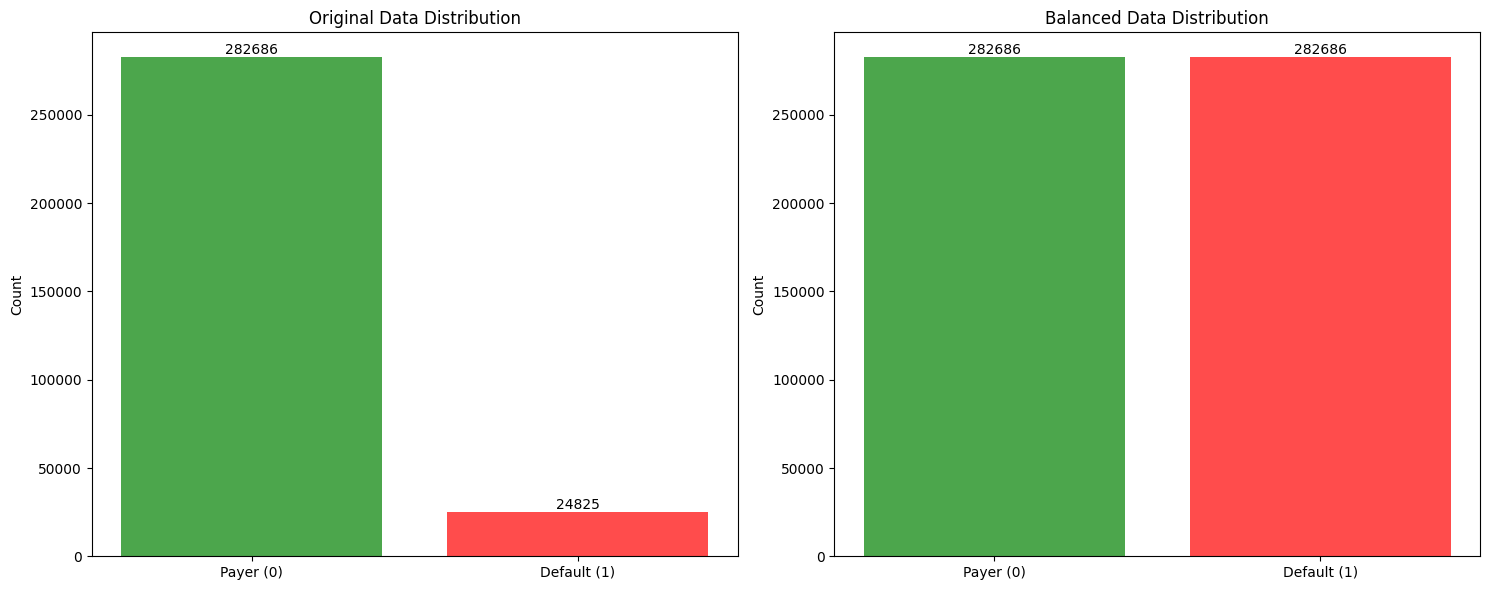

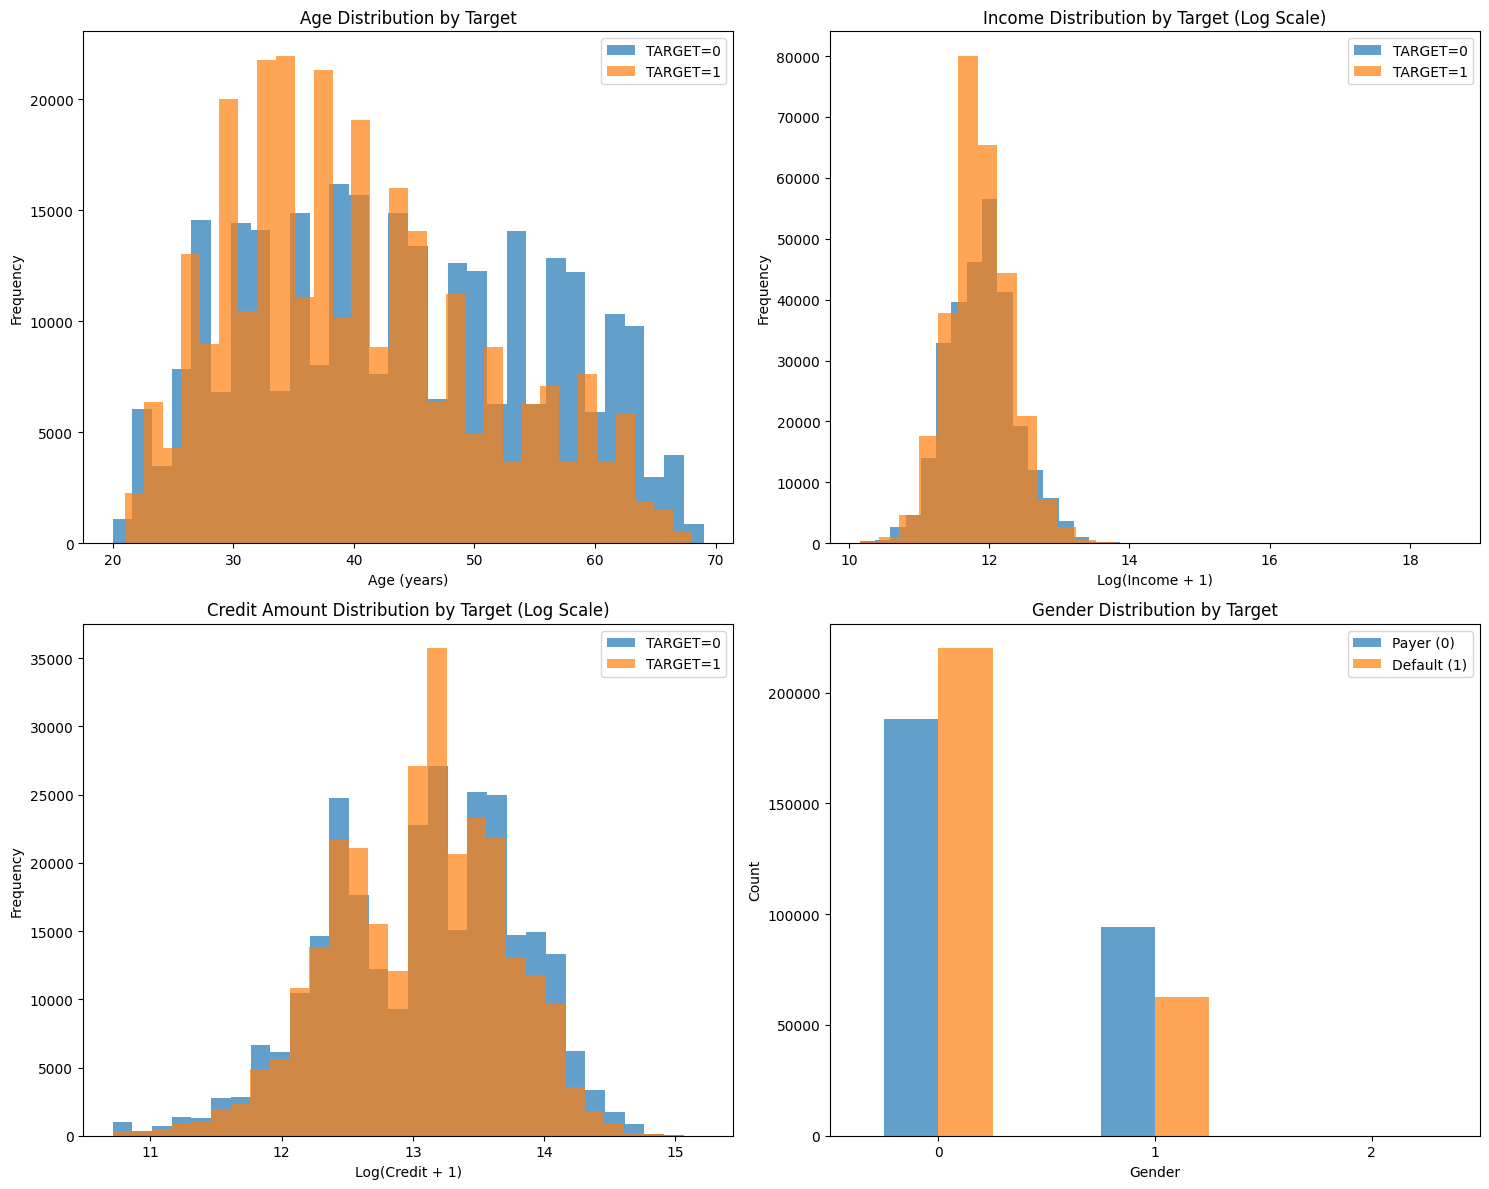


Step 6: Encoding columns for the model...
Handling missing values...
Encoding categorical variables...
Scaling numerical features...
Final processed data shape: (565372, 121)
Features: ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'OR

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,265 (106.50 KB)

 Trainable params: 26,881 (105.00 KB)

 Non-trainable params: 384 (1.50 KB)


Training the model...
Epoch 1/100
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 75s 6ms/step - accuracy: 0.8264 - loss: 0.3940 - precision: 0.8548 - recall: 0.7898 - val_accuracy: 0.8835 - val_loss: 0.2937 - val_precision: 0.9251 - val_recall: 0.8345 - learning_rate: 0.0010
Epoch 2/100
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - accuracy: 0.8678 - loss: 0.3181 - precision: 0.9077 - recall: 0.8189 - val_accuracy: 0.8898 - val_loss: 0.2718 - val_precision: 0.9104 - val_recall: 0.8646 - learning_rate: 0.0010
Epoch 3/100
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - accuracy: 0.8759 - loss: 0.3027 - precision: 0.9173 - recall: 0.8266 - val_accuracy: 0.8729 - val_loss: 0.3122 - val_precision: 0.8488 - val_recall: 0.9076 - learning_rate: 0.0010
Epoch 4/100
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 69s 6ms/step - accuracy: 0.8818 - loss: 0.2907 - precision: 0.9208 - recall: 0.8353 - val_accuracy: 0.8944 - val_loss: 0.2655 - val_precision: 0.9030 - val_recall: 0.8837 - learning_rate: 0.0010
Epoch 5/100
11308

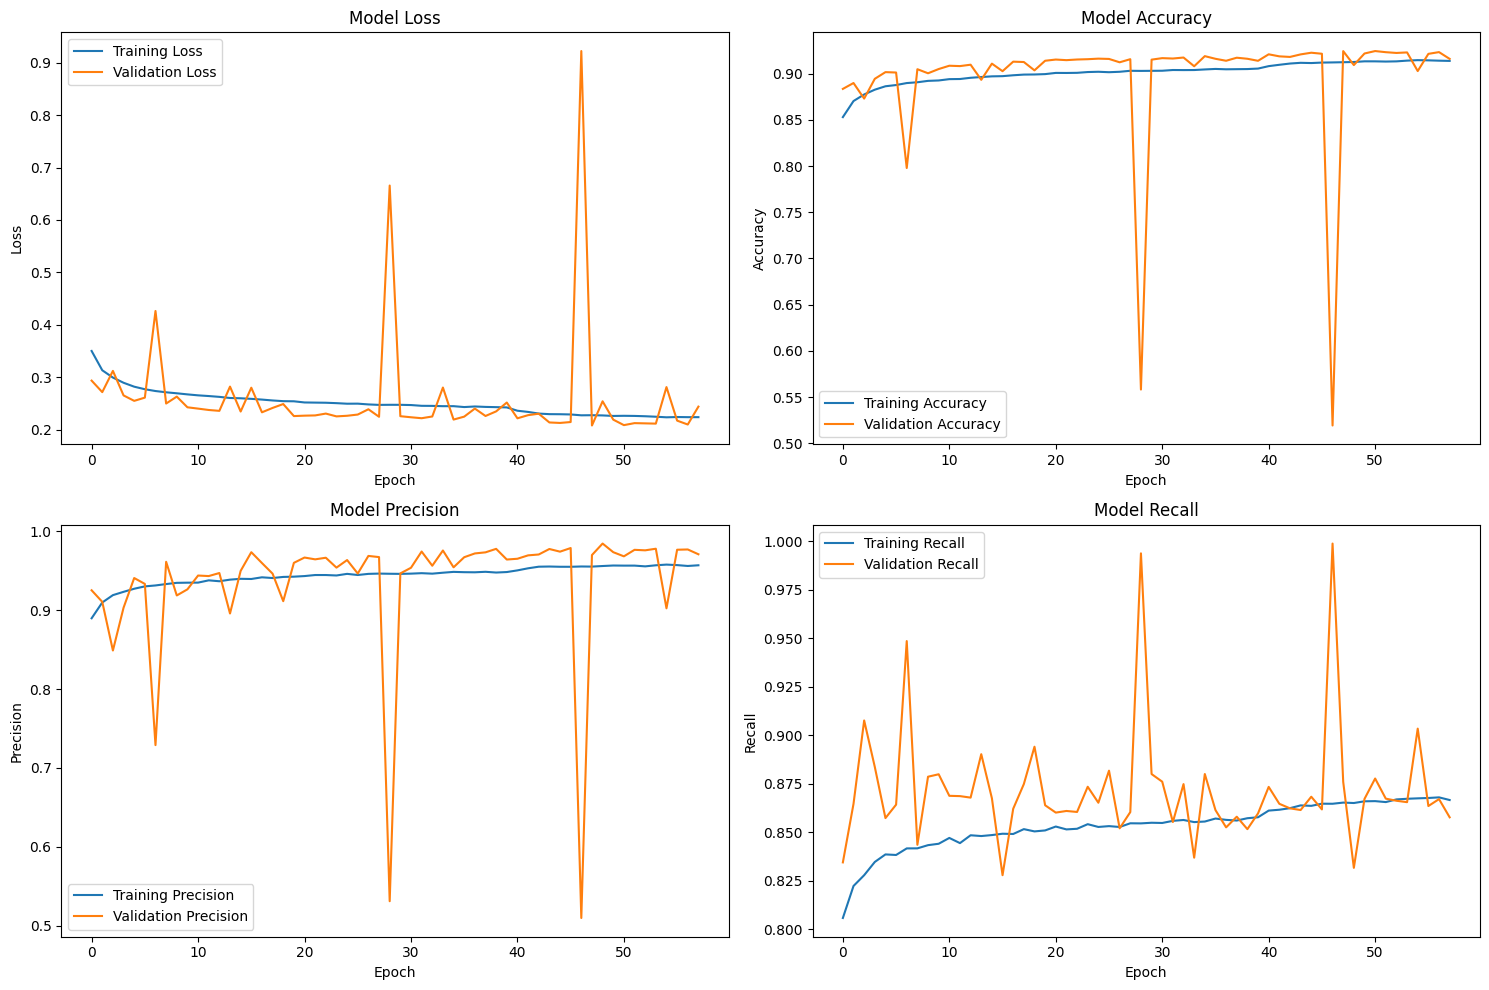


Step 7: Calculating Sensitivity (Recall)...
3534/3534 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
Confusion Matrix:
TN: 54904, FP: 1634
FN: 6978, TP: 49559

Metrics:
Sensitivity (Recall): 0.8766
Specificity: 0.9711
Precision: 0.9681
Accuracy: 0.9238


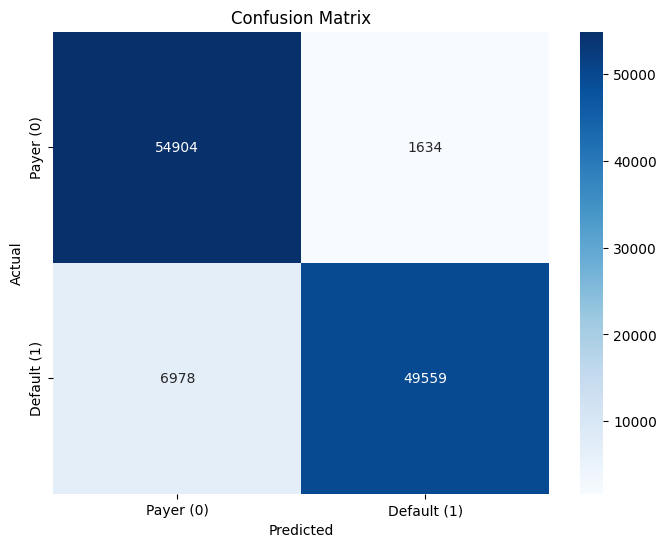


Detailed Classification Report:
              precision    recall  f1-score   support

   Payer (0)       0.89      0.97      0.93     56538
 Default (1)       0.97      0.88      0.92     56537

    accuracy                           0.92    113075
   macro avg       0.93      0.92      0.92    113075
weighted avg       0.93      0.92      0.92    113075


Step 8: Calculating ROC AUC...
3534/3534 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
ROC AUC Score: 0.9677


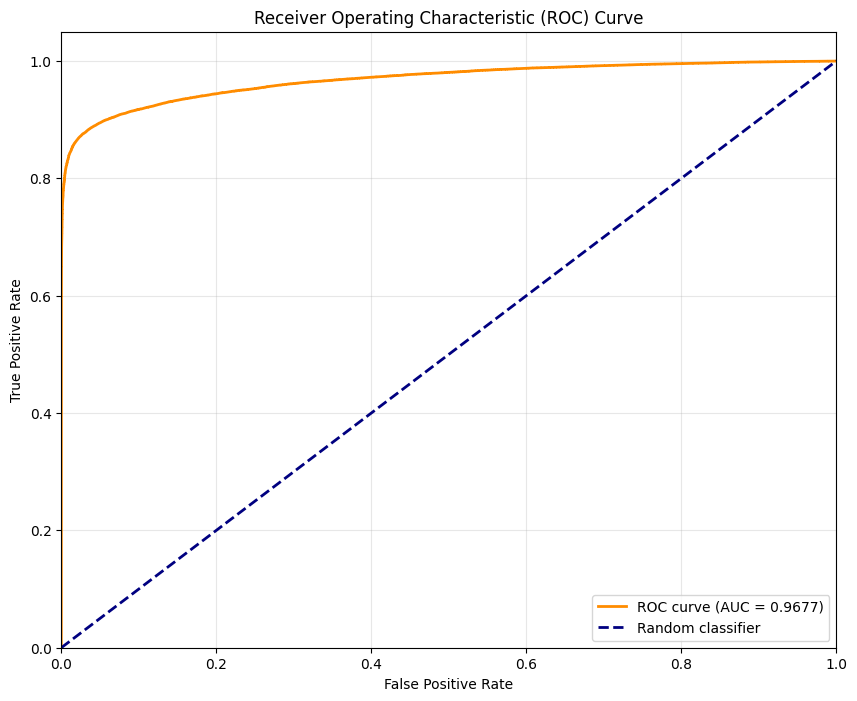


ANALYSIS COMPLETED SUCCESSFULLY!

Model is ready for predictions!
You can now use predictor.model.predict() for new predictions.


In [7]:
# Import the class from the same script or module
# If this is saved as loan_model.py, you can just use:
# from loan_model import LoanDefaultPredictor

if __name__ == "__main__":
    # Initialize the predictor
    predictor = LoanDefaultPredictor()

    # Run with your dataset file
    predictor.run_complete_analysis('loan_data.csv')

    # Optional: Use the model for new predictions
    print("\nModel is ready for predictions!")
    print("You can now use predictor.model.predict() for new predictions.")


In [8]:
# Step 1: Prepare your new data in a pandas DataFrame format
new_data = pd.DataFrame([{
    'CODE_GENDER': 'F',
    'FLAG_OWN_CAR': 'N',
    'FLAG_OWN_REALTY': 'Y',
    'CNT_CHILDREN': 0,
    'AMT_INCOME_TOTAL': 150000.0,
    'AMT_CREDIT': 500000.0,
    'AMT_ANNUITY': 20000.0,
    'AMT_GOODS_PRICE': 450000.0,
    'NAME_TYPE_SUITE': 'Unaccompanied',
    'NAME_INCOME_TYPE': 'Working',
    'NAME_EDUCATION_TYPE': 'Higher education',
    'NAME_FAMILY_STATUS': 'Married',
    'NAME_HOUSING_TYPE': 'House / apartment',
    'REGION_POPULATION_RELATIVE': 0.01,
    'DAYS_BIRTH': -12000,
    'DAYS_EMPLOYED': -2000,
    'DAYS_REGISTRATION': -3000,
    'DAYS_ID_PUBLISH': -1500,
    'OWN_CAR_AGE': 5,
    'FLAG_MOBIL': 1,
    'FLAG_EMP_PHONE': 1,
    'FLAG_WORK_PHONE': 0,
    'FLAG_CONT_MOBILE': 1,
    'FLAG_PHONE': 1,
    'FLAG_EMAIL': 0,
    'OCCUPATION_TYPE': 'Accountants',
    'CNT_FAM_MEMBERS': 3,
    'REGION_RATING_CLIENT': 2,
    'REGION_RATING_CLIENT_W_CITY': 2,
    'WEEKDAY_APPR_PROCESS_START': 'MONDAY',
    'HOUR_APPR_PROCESS_START': 9,
    'REG_REGION_NOT_LIVE_REGION': 0,
    'REG_REGION_NOT_WORK_REGION': 0,
    'LIVE_REGION_NOT_WORK_REGION': 0,
    'REG_CITY_NOT_LIVE_CITY': 0,
    'REG_CITY_NOT_WORK_CITY': 0,
    'LIVE_CITY_NOT_WORK_CITY': 0
}])

# Step 2: Encode categorical columns using saved encoders
for col, le in predictor.label_encoders.items():
    if col in new_data.columns:
        new_data[col] = new_data[col].fillna('Unknown')
        new_data[col] = le.transform(new_data[col])

# Step 3: Fill missing values for numerical columns
for col in new_data.select_dtypes(include=[np.number]).columns:
    new_data[col] = new_data[col].fillna(predictor.X_processed[col].median())

# Step 4: Scale the features
new_data_scaled = predictor.scaler.transform(new_data)

# Step 5: Make prediction
prediction_prob = predictor.model.predict(new_data_scaled)
prediction = (prediction_prob > 0.5).astype(int)

print(f"Predicted probability of default: {prediction_prob[0][0]:.4f}")
print(f"Predicted class (0 = Payer, 1 = Default): {prediction[0][0]}")


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- AMT_REQ_CREDIT_BUREAU_DAY
- AMT_REQ_CREDIT_BUREAU_HOUR
- AMT_REQ_CREDIT_BUREAU_MON
- AMT_REQ_CREDIT_BUREAU_QRT
- AMT_REQ_CREDIT_BUREAU_WEEK
- ...
